<a href="https://colab.research.google.com/github/gbaghdadi/NeuromatchDeepLearningProject/blob/main/NMAproject2023_LinearModel_StringerData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import KFold


In [17]:
# @title NMA Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [18]:
# @title NMA Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [19]:
# @title NMA Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [20]:
# @title Shape of each data

print('neuralActivity dimension:   ', dat['sresp'].shape)
print('stat dimension:  ', dat['stat'].shape)
print('running speed dimension:  ', dat['run'].shape)
print('pupil area dimension:  ', dat['pupilArea'].shape)
print('pupil xy position dimension:  ', dat['pupilCOM'].shape)
print('faceSVD dimension:   ',dat['beh_svd_time'].shape)

neuralActivity dimension:    (11983, 7018)
stat dimension:   (11983, 1)
running speed dimension:   (7018, 1)
pupil area dimension:   (7018, 1)
pupil xy position dimension:   (7018, 2)
faceSVD dimension:    (7018, 1000)


<class 'int'>
[2.0000e-02 4.0000e-02 6.0000e-02 ... 1.4032e+02 1.4034e+02 1.4036e+02]


[Text(0.5, 0, 'mins'), Text(0, 0.5, 'face SVD #5')]

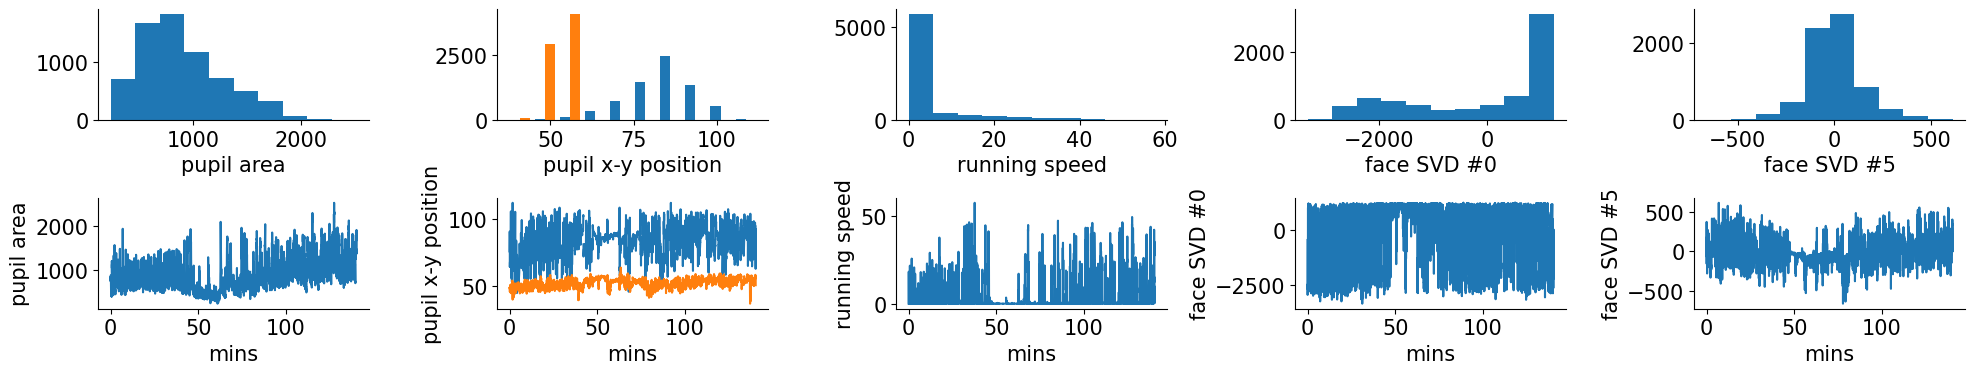

In [21]:
# @title Data visualizaion
length= dat['sresp'].shape[1]
print(type(length))
# time = np.ones((1,length))*1.2/60
time = np.arange(1,length+1)*1.2/60

print(time)
ax = plt.subplot(2,5,1)
plt.hist(dat['pupilArea'])
ax.set(xlabel='pupil area')

ax = plt.subplot(2,5,6)
plt.plot(time, dat['pupilArea'])
ax.set(xlabel='mins', ylabel = 'pupil area')
#--------------------------------------------------------------
ax = plt.subplot(2,5,2)
plt.hist(dat['pupilCOM'])
ax.set(xlabel='pupil x-y position')

ax = plt.subplot(2,5,7)
plt.plot(time, dat['pupilCOM'])
ax.set(xlabel='mins', ylabel = 'pupil x-y position')
#--------------------------------------------------------------
ax = plt.subplot(2,5,3)
plt.hist(dat['run'])
ax.set(xlabel='running speed')

ax = plt.subplot(2,5,8)
plt.plot(time, dat['run'])
ax.set(xlabel='mins', ylabel = 'running speed')
#--------------------------------------------------------------
ax = plt.subplot(2,5,4)
plt.hist(dat['beh_svd_time'][:,0])
ax.set(xlabel='face SVD #0')

ax = plt.subplot(2,5,9)
plt.plot(time, dat['beh_svd_time'][:,0])
ax.set(xlabel='mins', ylabel = 'face SVD #0')
#--------------------------------------------------------------
ax = plt.subplot(2,5,5)
plt.hist(dat['beh_svd_time'][:,5])
ax.set(xlabel='face SVD #5')

ax = plt.subplot(2,5,10)
plt.plot(time, dat['beh_svd_time'][:,5])
ax.set(xlabel='mins', ylabel = 'face SVD #5')

In [28]:
# @title Input and Output of the Model

neural_activity = dat['sresp']    # Input
run_speed = dat['run']            # Output
pupil_area = dat['pupilArea']     # Output
face_svd = dat['beh_svd_time']    # Output

print('Input dimension:  ', neural_activity.shape)
print('Output dimension:  ',run_speed.shape)

print('Output dimension(face SVD):  ',face_svd.shape)


Input dimension:   (11983, 7018)
Output dimension:   (7018, 1)
Output dimension(face SVD):   (7018, 1000)


In [29]:
# reshaping input and output
neural_activity = np.transpose(neural_activity)
runspeed = run_speed.squeeze()
pupilarea = pupil_area.squeeze()
facesvd = face_svd[:,:100]

print('Input dimension:  ', neural_activity.shape)
print('Output dimension:  ',runspeed.shape)
print('Output dimension (face SVD):  ',facesvd.shape)

Input dimension:   (7018, 11983)
Output dimension:   (7018,)
Output dimension (face SVD):   (7018, 100)


In [30]:
# @title Dimension Reduction of the Input using PCA
pca_model = PCA(n_components=500)
reduced = pca_model.fit_transform(neural_activity)
component = pca_model.components_
neural_activity = reduced
print(neural_activity.shape)
# print(component.shape)

(7018, 500)


#**Linear Model:     neural activity -> running speed**




In [31]:
# @title Split data using Kfold
num_of_folds = 10
kf = KFold(n_splits=num_of_folds, shuffle=False)
split = kf.split(neural_activity)
err_mse_all = np.empty(num_of_folds)
acc_r2_all = np.empty(num_of_folds)
counter = 0

for train_index, test_index in split:
  X_train, X_test = neural_activity[train_index, :], neural_activity[test_index, :]
  y_train, y_test = runspeed[train_index], runspeed[test_index]

  # Build linear regression model to predict puiple area using sklearn
  model1 = LinearRegression()
  # fit it to data
  model1.fit(X_train, y_train)
  # predict pupile area
  y_pred = model1.predict(X_test)
  # calculate the accuracy
  err_mse_all[counter] = mean_squared_error(y_test, y_pred,squared=False)
  acc_r2_all[counter] = r2_score(y_test, y_pred)
  counter +=1

# print("The r2 value of linear regression is: ", acc_r2_all)
# print("The mse value of linear regression is: ", err_mse_all)
print("mean r2: ", np.mean(acc_r2_all), "std r2: ", np.std(acc_r2_all))
print("mean mse: ", np.mean(err_mse_all), "std mse: ", np.std(err_mse_all))


mean r2:  0.7977139181024442 std r2:  0.08688613653524241
mean mse:  3.5226605966526656 std mse:  0.9234099404780837


(701,)
(701,)


(0.0, 49.45829685447109)

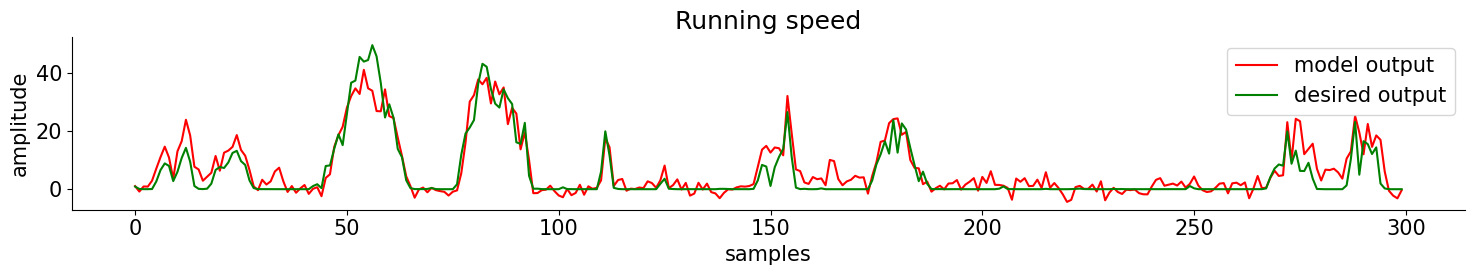

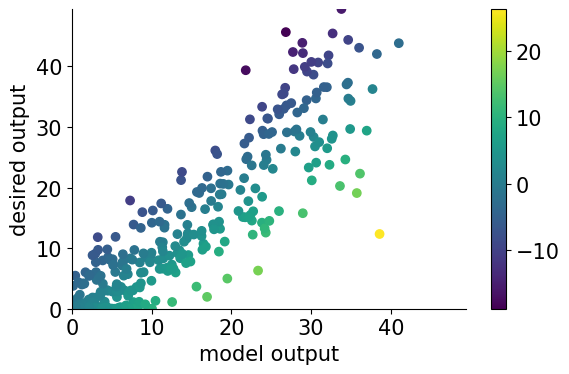

In [32]:
# @title Results of linear decoding of running speed
print(y_pred.shape)
print(y_test.shape)
plt.figure(figsize=(15,3))
plt.plot(y_pred[0:300], color = 'r', label = "model output")
plt.plot(y_test[0:300], color = 'g', label = "desired output")
plt.legend()
plt.xlabel("samples")
plt.ylabel("amplitude")
plt.title('Running speed')

plt.figure(figsize=(6,4))
err = y_pred - y_test
plt.scatter(y_pred, y_test, c=err)
plt.xlabel("model output")
plt.ylabel("desired output")
plt.colorbar()
plt.xlim((0, np.max([y_pred, y_test])))
plt.ylim((0, np.max([y_pred, y_test])))

#**Linear Model:       Neural Activities -> Pupil Area**

In [33]:
# @title Split data using Kfold
num_of_folds = 10
kf = KFold(n_splits=num_of_folds, shuffle=False)
split = kf.split(neural_activity)
err_mse_all = np.empty(num_of_folds)
acc_r2_all = np.empty(num_of_folds)
counter = 0
print(neural_activity.shape)

for train_index, test_index in split:
  X_train, X_test = neural_activity[train_index, :], neural_activity[test_index, :]
  y_train, y_test = pupilarea[train_index], pupilarea[test_index]

  # Build linear regression model to predict puiple area using sklearn
  model1 = LinearRegression()
  # fit it to data
  model1.fit(X_train, y_train)
  # predict pupile area
  y_pred = model1.predict(X_test)
  # calculate the accuracy
  err_mse_all[counter] = mean_squared_error(y_test, y_pred,squared=False)
  acc_r2_all[counter] = r2_score(y_test, y_pred)
  counter +=1

# print("The r2 value of linear regression is: ", acc_r2_all)
# print("The mse value of linear regression is: ", err_mse_all)
print("mean r2: ", np.mean(acc_r2_all), "std r2: ", np.std(acc_r2_all))
print("mean mse: ", np.mean(err_mse_all), "std mse: ", np.std(err_mse_all))


(7018, 500)
mean r2:  0.7472119468103812 std r2:  0.09485356234237925
mean mse:  151.73846565237878 std mse:  29.763501895966254


(701,)
(701,)


(0.0, 2520.456081550447)

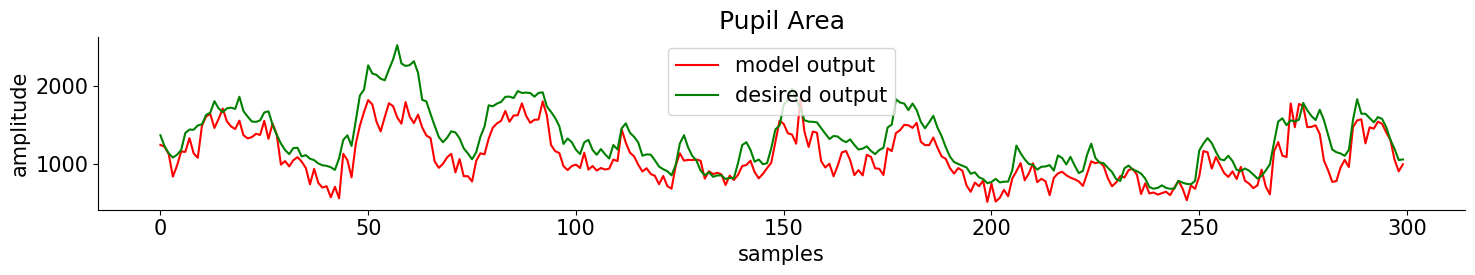

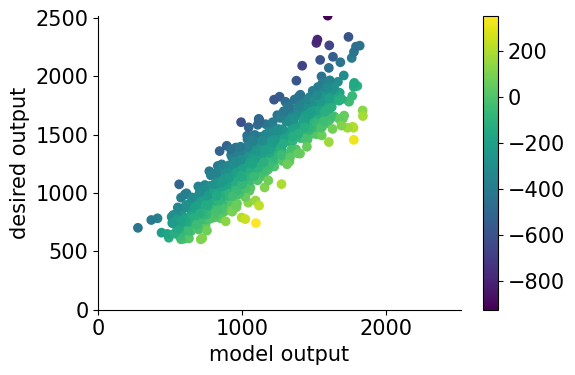

In [34]:
# @title Results of linear decoding of running speed
print(y_pred.shape)
print(y_test.shape)
plt.figure(figsize=(15,3))
plt.plot(y_pred[0:300], color = 'r', label = "model output")
plt.plot(y_test[0:300], color = 'g', label = "desired output")
plt.legend()
plt.xlabel("samples")
plt.ylabel("amplitude")
plt.title('Pupil Area')

plt.figure(figsize=(6,4))
err = y_pred - y_test
plt.scatter(y_pred, y_test, c=err)
plt.xlabel("model output")
plt.ylabel("desired output")
plt.colorbar()
plt.xlim((0, np.max([y_pred, y_test])))
plt.ylim((0, np.max([y_pred, y_test])))

# **Multioutput Regression    neural activity-> face SVD**

In [35]:
# @title Split data using Kfold
num_of_folds = 10
kf = KFold(n_splits=num_of_folds, shuffle=False)
split = kf.split(neural_activity)
err_mse_all = np.empty(num_of_folds)
acc_r2_all = np.empty(num_of_folds)
counter = 0

for train_index, test_index in split:
  X_train, X_test = neural_activity[train_index, :], neural_activity[test_index, :]
  y_train, y_test = facesvd[train_index], facesvd[test_index]

  # Build linear regression model to predict puiple area using sklearn
  model1 = LinearRegression()
  # fit it to data
  model1.fit(X_train, y_train)
  # predict pupile area
  y_pred = model1.predict(X_test)
  # calculate the accuracy
  err_mse_all[counter] = mean_squared_error(y_test, y_pred,squared=False)
  acc_r2_all[counter] = r2_score(y_test, y_pred)
  counter +=1

# print("The r2 value of linear regression is: ", acc_r2_all)
# print("The mse value of linear regression is: ", err_mse_all)
print("mean r2: ", np.mean(acc_r2_all), "std r2: ", np.std(acc_r2_all))
print("mean mse: ", np.mean(err_mse_all), "std mse: ", np.std(err_mse_all))


mean r2:  -0.08522567497550265 std r2:  0.09079647730263637
mean mse:  58.54383649947099 std mse:  7.550970843731442


In [36]:
print(y_pred.shape)

(701, 100)


(701, 100)
(701, 100)


Text(0.5, 1.0, 'Face SVD')

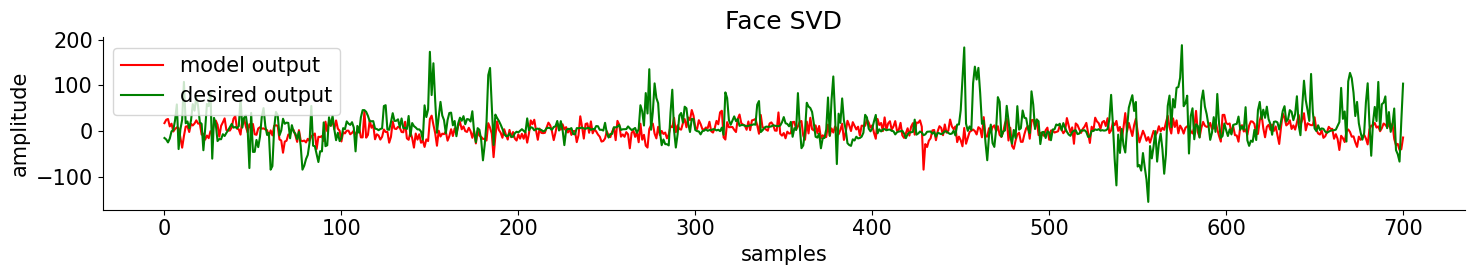

In [44]:
# @title Results of linear decoding of running speed
print(y_pred.shape)
print(y_test.shape)
plt.figure(figsize=(15,3))
plt.plot(y_pred[:,80], color = 'r', label = "model output")
plt.plot(y_test[:,80], color = 'g', label = "desired output")
plt.legend()
plt.xlabel("samples")
plt.ylabel("amplitude")
plt.title('Face SVD')

# plt.figure(figsize=(6,4))
# err = y_pred - y_test
# plt.scatter(y_pred, y_test, c=err)
# plt.xlabel("model output")
# plt.ylabel("desired output")
# plt.colorbar()
# plt.xlim((0, np.max([y_pred, y_test])))
# plt.ylim((0, np.max([y_pred, y_test])))